# 异常值处理

在做EDA时，什么是最重要的，就是数据清洗的过程，去除对于数据建模有害的所有异常数据是必要的，但是要注意，并非所有统计性异常数据就都需要去除，如果事出有因，那么我们也要选择性的去除。

> Not every outlier is a wrong value!

那么什么是异常值呢？

> In statistics, an outlier is an observation point that is distant from other observations.

很明确了，和大部分点相距较远的就属于异常值。

---


导致异常值的最常见原因有：

- 数据输入错误（人为错误）

- 测量误差（仪器误差）

- 实验错误（数据提取或实验计划/执行错误）

- 故意的（虚假的异常值用于测试异常值检测方法）

- 数据处理错误（数据处理或数据集意外突变）

- 抽样错误（从错误或各种不同来源提取或混合数据）

- 自然引入（并不是错误，而是数据多样性导致的数据新颖性）



异常检测的方法：
 
- 基于【模型】的技术：首先建立一个数据模型，异常是那些同模型不能完美拟合的对象；如果模型是簇的集合，则异常是不显著属于任何簇的对象；在使用回归模型时，异常是相对远离预测值的对象。
 
- 基于【邻近】的技术：通常可以在对象之间定义邻近性度量，异常对象是那些远离其他对象的对象。
 
- 基于【密度】的技术：仅当一个点的局部密度显著低于它的大部分近邻时才将其分类为离群点。



In [1]:
# import packages

# data processing
import pandas as pd
import numpy as np
from datetime import timedelta, datetime


import re

# data visualization
import plotly.graph_objs as go
from plotly.graph_objs import Bar, Layout
from plotly import offline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20, 10)

plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号

# change text color
import colorama
from colorama import Fore, Style

# IPython
from IPython.display import IFrame

%matplotlib inline

In [2]:
# 读取数据

train = pd.read_csv("train.gz")
test = pd.read_csv("test.gz")

In [3]:
# 全集
fullset = pd.concat([train,test],ignore_index=True)

## 检测outlier的方法


**Univariate**

- [Boxplot](#Boxplot)
- [Zscore](#Zscore)
- [IQR](#IQR)
- [Hampel](#Hampel)

**Multivariate**

- [DBSCAN](#DBSCAN)
- [OneClassSVM](#OneClassSVM)
- [EllipticEnvelope](#EllipticEnvelope)
- [IsolationForest](#IsolationForest)
- [LocalOutlierFactor](#LocalOutlierFactor)

### Boxplot

![](https://miro.medium.com/max/1400/1*0MPDTLn8KoLApoFvI0P2vQ.png)

In [4]:
sample = fullset.sample(random_state=0,frac = .1)
sample = sample.replace(-1,np.nan)

In [5]:
from data_management import meta

In [6]:
metadata = meta(train,test)

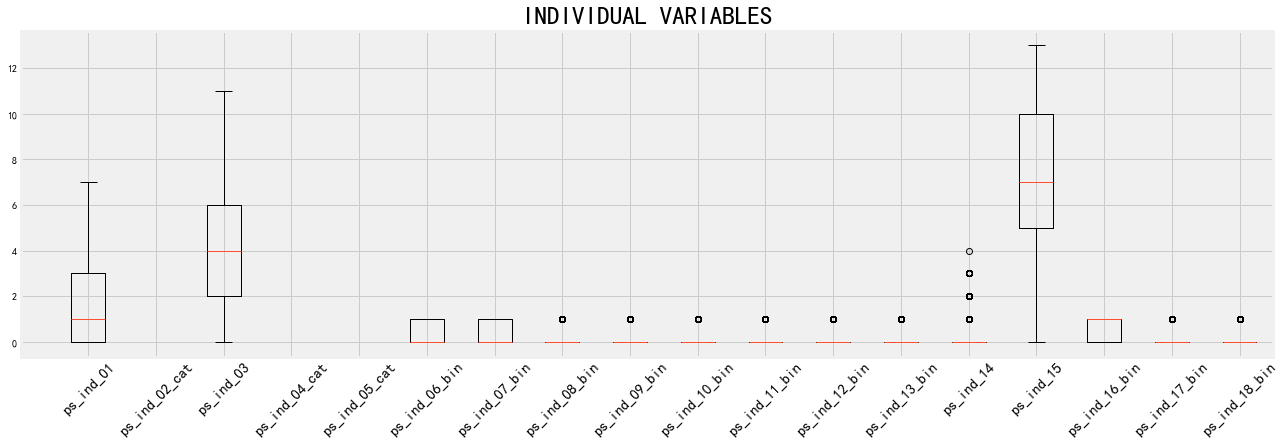

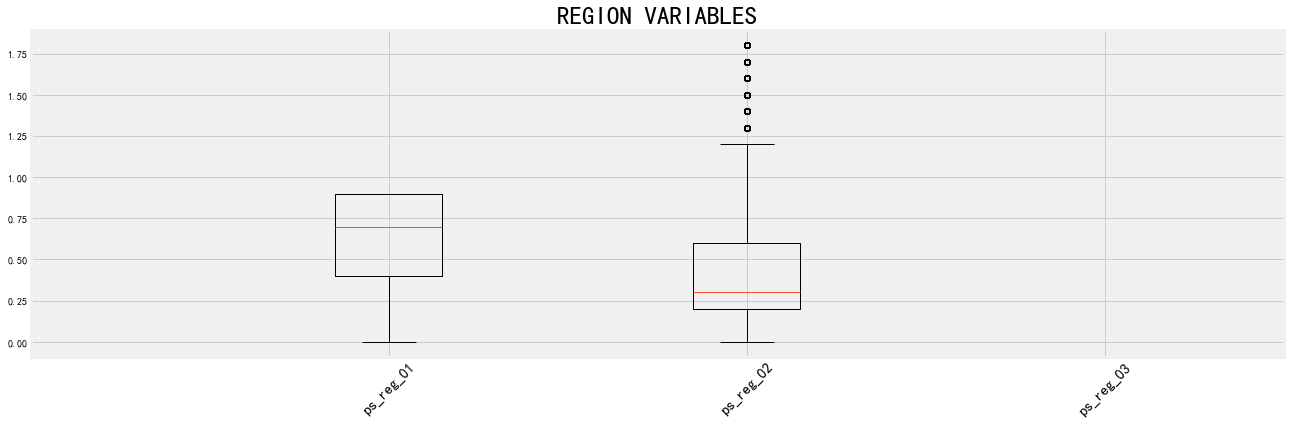

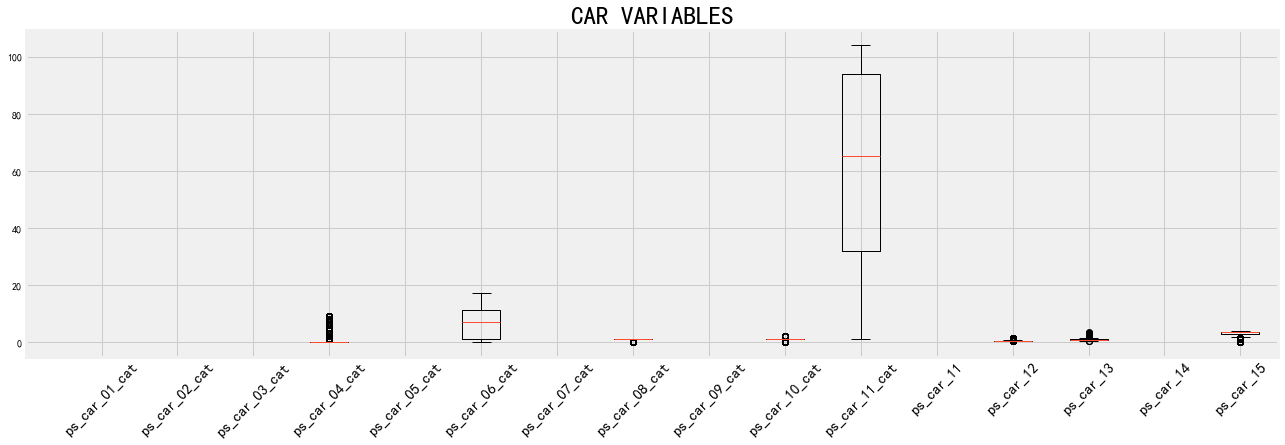

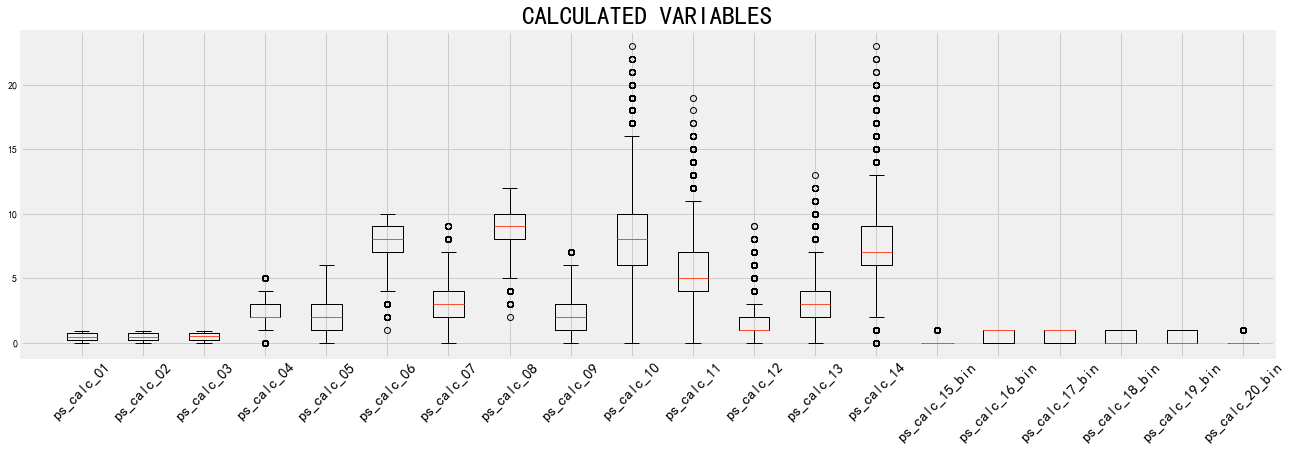

In [7]:
plt.figure(figsize = (20,6))
ind_idx = metadata[metadata['category'] == 'individual'].index
ticks = list(ind_idx)
ticks = [''] + ticks
box1 = plt.boxplot(sample[ind_idx])
rang = range(0, len(ticks))
plt.title("individual variables".upper(),fontsize = 25)
plt.xticks(rang, ticks, rotation=45, fontsize = 15)
pass

plt.figure(figsize = (20,6))
ind_idx = metadata[metadata['category'] == 'region'].index
ticks = list(ind_idx)
ticks = [''] + ticks
box2 = plt.boxplot(sample[ind_idx])
rang = range(0, len(ticks))
plt.title("region variables".upper(),fontsize = 25)
plt.xticks(rang, ticks, rotation=45, fontsize = 15)
pass

plt.figure(figsize = (20,6))
ind_idx = metadata[metadata['category'] == 'car'].index
ticks = list(ind_idx)
ticks = [''] + ticks
box3 = plt.boxplot(sample[ind_idx])
rang = range(0, len(ticks))
plt.title("car variables".upper(),fontsize = 25)
plt.xticks(rang, ticks, rotation=45, fontsize = 15)
pass

plt.figure(figsize = (20,6))
ind_idx = metadata[metadata['category'] == 'calculated'].index
ticks = list(ind_idx)
ticks = [''] + ticks
box4 = plt.boxplot(sample[ind_idx])
rang = range(0, len(ticks))
plt.title("calculated variables".upper(),fontsize = 25)
plt.xticks(rang, ticks, rotation=45, fontsize = 15)
pass

这里我们用简单的boxplot对不同类型的变量做了异常值的检验，对于类别型变量，可能会看到只有一条线的情况，那是因为该类别是dominant，是该变量出现频率最高的类，再来看一下连续型变量，主要集中在calculated变量，看到会有一些异常点存在，但是并没有距离正常分布很远。

下面来看一下如何找到这些异常值呢？

In [8]:
# from matplotlib.cbook import boxplot_stats  
# boxplot_data = sample[metadata.index]
# for idx,i in enumerate(boxplot_stats(boxplot_data)):
#     outliers = i['fliers'] if len(i['fliers']) > 0 else 'No Outliers'
#     print(f"{boxplot_data.columns[idx]}==>{outliers}")

上面这段代码可以找到具体的缺失值是哪些！

### Zscore

> The Z-score（标准分数） is the signed number of standard deviations by which the value of an observation or data point is above the mean value of what is being observed or measured.


> Z-score is finding the distribution of data where mean is 0 and standard deviation is 1 i.e. normal distribution.

$$
z = \frac{(x-\mu)}{\sigma}
$$

那么，如何利用z-score来检测异常值呢？当计算z-score时，我们实际在数据中心化，并且寻找距离零点比较远的数据点，这就说明是离群的，一般来说z-score大于3或者小于-3，就说明此数据点是离群的。

In [9]:
from scipy import stats
z_score = np.abs(stats.zscore(fullset))

In [10]:
threshold = 3
np.where(z_score > 3)

(array([      2,       5,      10, ..., 1488023, 1488023, 1488023],
       dtype=int64),
 array([ 3, 21, 26, ..., 26, 35, 36], dtype=int64))

In [11]:
np.where(z_score > 3)[0].shape

(524548,)

In [12]:
# for r,c,in zip(np.where(z_score > 3)[0],np.where(z_score > 3)[1]):
#     print(fullset.iloc[r,c])

z-score这个方法并不robust，可以看出有50多万的数据被定义为了异常值，这很离谱，并且也不是很容易就能提取定位到要处理的缺失值，z-score一般常用于数据量不大，维度较小、连续型变量较多的数据集。

### IQR

> The interquartile range (IQR), also called the midspread or middle 50%, or technically H-spread, is a measure of statistical dispersion, being equal to the difference between 75th and 25th percentiles, or between upper and lower quartiles, IQR = Q3 − Q1.

In [13]:
IFrame(width="853",height="480",src = "https://www.youtube.com/embed/wsKyhcXmKbo")

In [14]:
iqr_df = fullset.drop(['id','target'],axis=1)
Q1 = iqr_df.quantile(0.25)
Q3 = iqr_df.quantile(0.75)
IQR = Q3 - Q1

In [15]:
cond = (iqr_df < (Q1 - 1.5 * IQR)) |(iqr_df > (Q3 + 1.5 * IQR))

In [16]:
iqr_df[~cond].replace(np.nan,'异常值')

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,2,2.0,5,1,0.0,0,1,0.0,0.0,0.0,...,9.0,1.0,5.0,8.0,0.0,1,1,0,0,异常值
1,1,1.0,7,0,0.0,0,0,异常值,0.0,0.0,...,3.0,1.0,1.0,9.0,0.0,1,1,0,1,0.0
2,5,异常值,9,1,0.0,0,0,异常值,0.0,0.0,...,4.0,2.0,7.0,7.0,0.0,1,1,0,1,0.0
3,0,1.0,2,0,0.0,1,0,0.0,0.0,0.0,...,2.0,2.0,4.0,9.0,0.0,0,0,0,0,0.0
4,0,2.0,0,1,0.0,1,0,0.0,0.0,0.0,...,3.0,1.0,1.0,3.0,0.0,0,0,1,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1488023,0,1.0,6,0,0.0,0,1,0.0,0.0,0.0,...,4.0,2.0,3.0,4.0,0.0,1,0,0,1,0.0
1488024,5,3.0,5,1,0.0,0,0,异常值,0.0,0.0,...,6.0,2.0,2.0,11.0,0.0,0,1,1,0,0.0
1488025,0,1.0,5,0,0.0,1,0,0.0,0.0,0.0,...,5.0,2.0,2.0,11.0,0.0,1,1,0,0,0.0
1488026,6,1.0,5,1,0.0,0,0,0.0,异常值,0.0,...,1.0,1.0,2.0,7.0,异常值,1,0,0,0,0.0


值得一提的就是IQR筛选出来的值就是boxplot所筛出来的值，他们是一样的！

```diff
+ 优点：简单粗暴，可解释性强
- 缺点：鲁棒性差，准确性差，只能剔除明显的异常值
```

### Hampel

Hampel filter常用于时间序列的异常值处理，说白了就是单变量的异常值处理，这里简要介绍一下原理。

In [17]:
def random_walk_with_outliers(origin, n_steps, perc_outliers=0.0, outlier_mult=10, seed=42):

    assert (perc_outliers >= 0.0) & (perc_outliers <= 1.0)
    
    #set seed for reproducibility
    np.random.seed(seed)
    
    # possible steps
    steps = [-1, 1]

    # simulate steps
    steps = np.random.choice(a=steps, size=n_steps-1)
    rw = np.append(origin, steps).cumsum(0)
    
    # add outliers
    n_outliers = int(np.round(perc_outliers * n_steps, 0))
    indices = np.random.randint(0, len(rw), n_outliers)
    rw[indices] = rw[indices] + steps[indices + 1] * outlier_mult
    
    return rw, indices

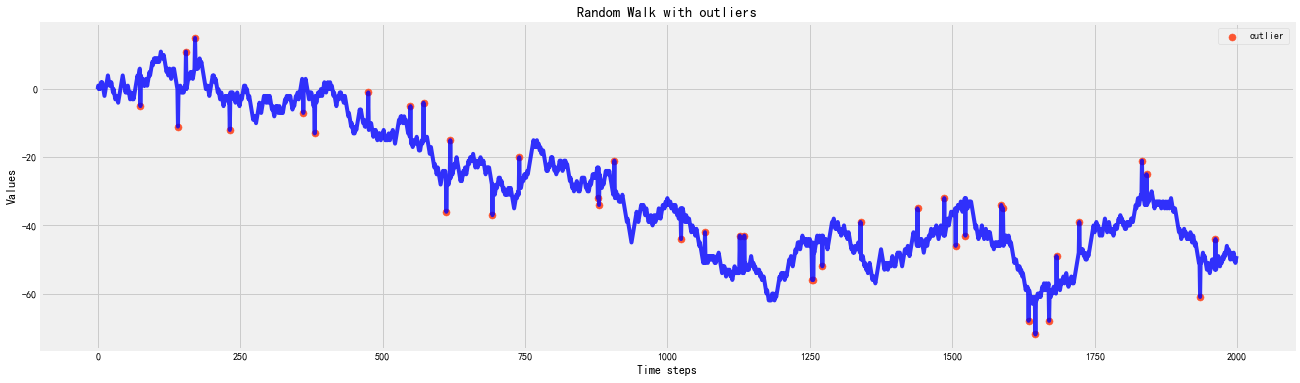

In [18]:
plt.figure(figsize = [20,6])
rw, outlier_ind = random_walk_with_outliers(0, 2000, 0.02,seed = 2022)
plt.plot(np.arange(len(rw)), rw, c = 'b',alpha = .8)
plt.scatter(outlier_ind, rw[outlier_ind], c='#fc5531', label='outlier',s = 50)
plt.title('Random Walk with outliers')
plt.xlabel('Time steps')
plt.ylabel('Values')
plt.legend();

Hampel方法是基于窗口函数和绝对中位偏差（MAD)的离群值检测方法。

既然，均值和标准差这两种指标对异常值十分敏感，那么我们是不是可以换一种基本统计量来替代他们，比如中位数和MAD。

$$
\tilde X = median(X) \\
MAD = median(|X_i - \tilde X|)
$$


Hampel通过一个滑动窗口计算窗口内数据的中位数、数据点到中位数的绝对偏差（MAD）为了使MAD成为标准差的一致估计（consistent estimator）,我们要乘一个系数 k，对于高斯分布，k = 1.4826。

检查 `k*MAD` 是否大于偏差的中位数的 m (一般是4.5）倍，如果大于，则被认为是离群值。

`abs(窗口数据 - 窗口数据中位数)> K*MAD*m`

**优点：**<font color='red'>鲁棒性更强，更稳定</font>

**缺点：**<font color='#3198FB'>数据应满足正态分布</font>

In [19]:
def evaluation(series, true_indices, detected_indices):
    # calculate metrics
    tp = list(set(detected_indices).intersection(set(true_indices)))
    fp = list(set(detected_indices).difference(set(true_indices)))
    fn = list(set(true_indices).difference(set(detected_indices)))
    perc_detected = 100 * len(tp) / len(true_indices)
    
    # create the plot
    fix, ax = plt.subplots(2, 1, figsize=(25, 6*3))
    
    ax[0].plot(np.arange(len(series)), series,c = '#24292e',alpha = .8, linewidth = .5);
    ax[0].scatter(true_indices, series[true_indices], c='g', label='true outlier',s = 100)
    ax[0].set_title('实际离群值',fontsize = 35)
    ax[0].legend(fontsize = 20)
    
    ax[1].plot(np.arange(len(series)), series, c = '#3a9cfb',alpha = .8, linewidth = .5);
    ax[1].scatter(tp, series[tp], c='g', label='true positive',s = 100)
    ax[1].scatter(fp, series[fp], c='r', marker = 'x', label='false positive', s = 100)
    ax[1].scatter(fn, series[fn], c='k', marker = 'x', label='false negative', s = 100)
    ax[1].set_title('处理后结果对比',fontsize = 35)
    ax[1].legend(fontsize = 20)
    
    
    # print out summary
    print('-' * 25 + ' Summary ' + '-' * 25)
    print(f'序列中离群值数量: {len(true_indices)}')
    print(f'所检测出来的数量: {len(detected_indices)}')
    print(f'检测正确的数量: {len(tp)} ({perc_detected:.2f}% of all outliers).')
    print('-' * 59)
    
    return tp, fp, fn

In [20]:
def hampel_filter(input_series, window_size, n_sigmas=3):
    
    n = len(input_series)
    new_series = input_series.copy()
    
    k = 1.4826 # 定义K，应对高斯分布

    indices = []

    # possibly use np.nanmedian 
    for i in range((window_size),(n - window_size)):  # 移动窗口
        # 计算窗口内数据的MAD
        window_median = np.median(input_series[(i - window_size):(i + window_size)])
        k_MAD = k * np.median(np.abs(input_series[(i - window_size):(i + window_size)] - window_median))
        if (np.abs(input_series[i] - window_median) > n_sigmas * k_MAD):
            new_series[i] = window_median
            indices.append(i)    
    return new_series, indices

In [21]:
def iqr_filter(input_series, window_size):
    
    n = len(input_series)
    new_series = input_series.copy()
    indices = []
    # possibly use np.nanmedian 
    for i in range((window_size),(n - window_size)):  # 移动窗口
        # 计算窗口内数据的MAD
        s = input_series[(i - window_size):(i + window_size)]
        s = pd.Series(s)
        Q1 = s.quantile(0.25)
        Q3 = s.quantile(0.75)
        IQR = Q3 - Q1
        cond = (input_series[i] < (Q1 - 1.5 * IQR)) |(input_series[i] > (Q3 + 1.5 * IQR))
        if cond:
            new_series[i] = input_series[i]
            indices.append(i)  
    return new_series, indices

In [22]:
res_iqr, detected_outliers_iqr = iqr_filter(rw, 10)
res_hampel, detected_outliers_hampel = hampel_filter(rw, 10)

Hampel处理后 vs. IQR处理后

------------------------- Summary -------------------------
序列中离群值数量: 40
所检测出来的数量: 45
检测正确的数量: 38 (95.00% of all outliers).
-----------------------------------------------------------


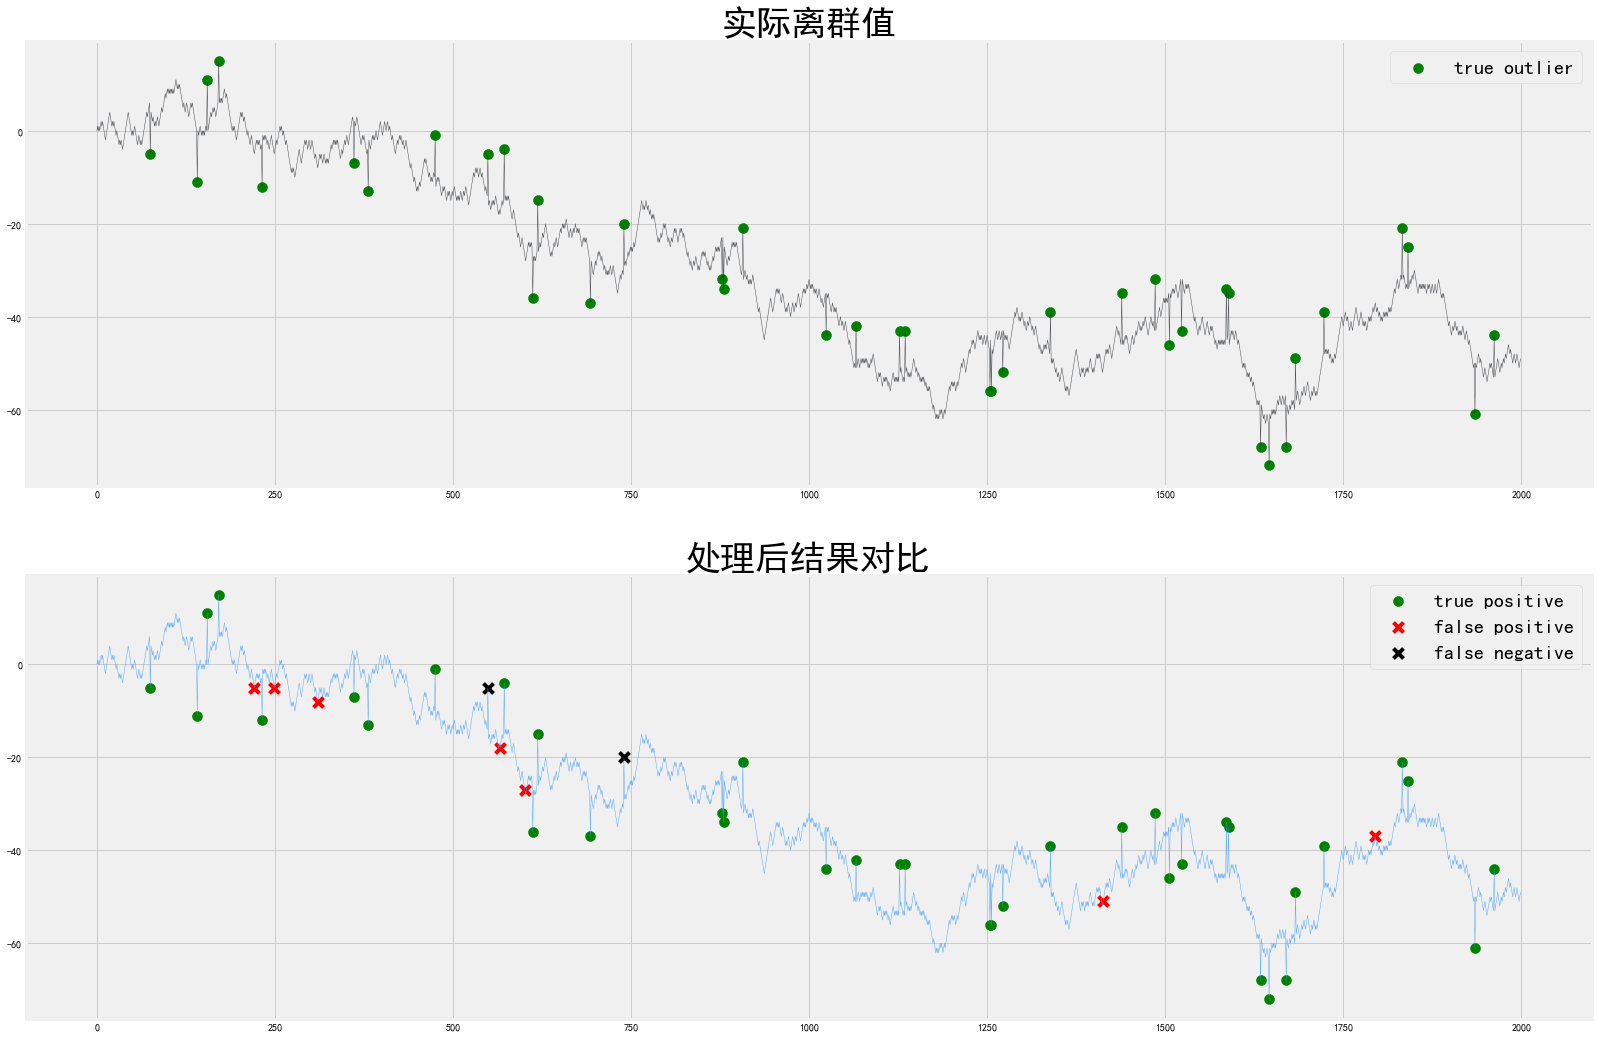

In [23]:
# Hampel
tp, fp, fn = evaluation(rw, outlier_ind, detected_outliers_hampel)

------------------------- Summary -------------------------
序列中离群值数量: 40
所检测出来的数量: 44
检测正确的数量: 37 (92.50% of all outliers).
-----------------------------------------------------------


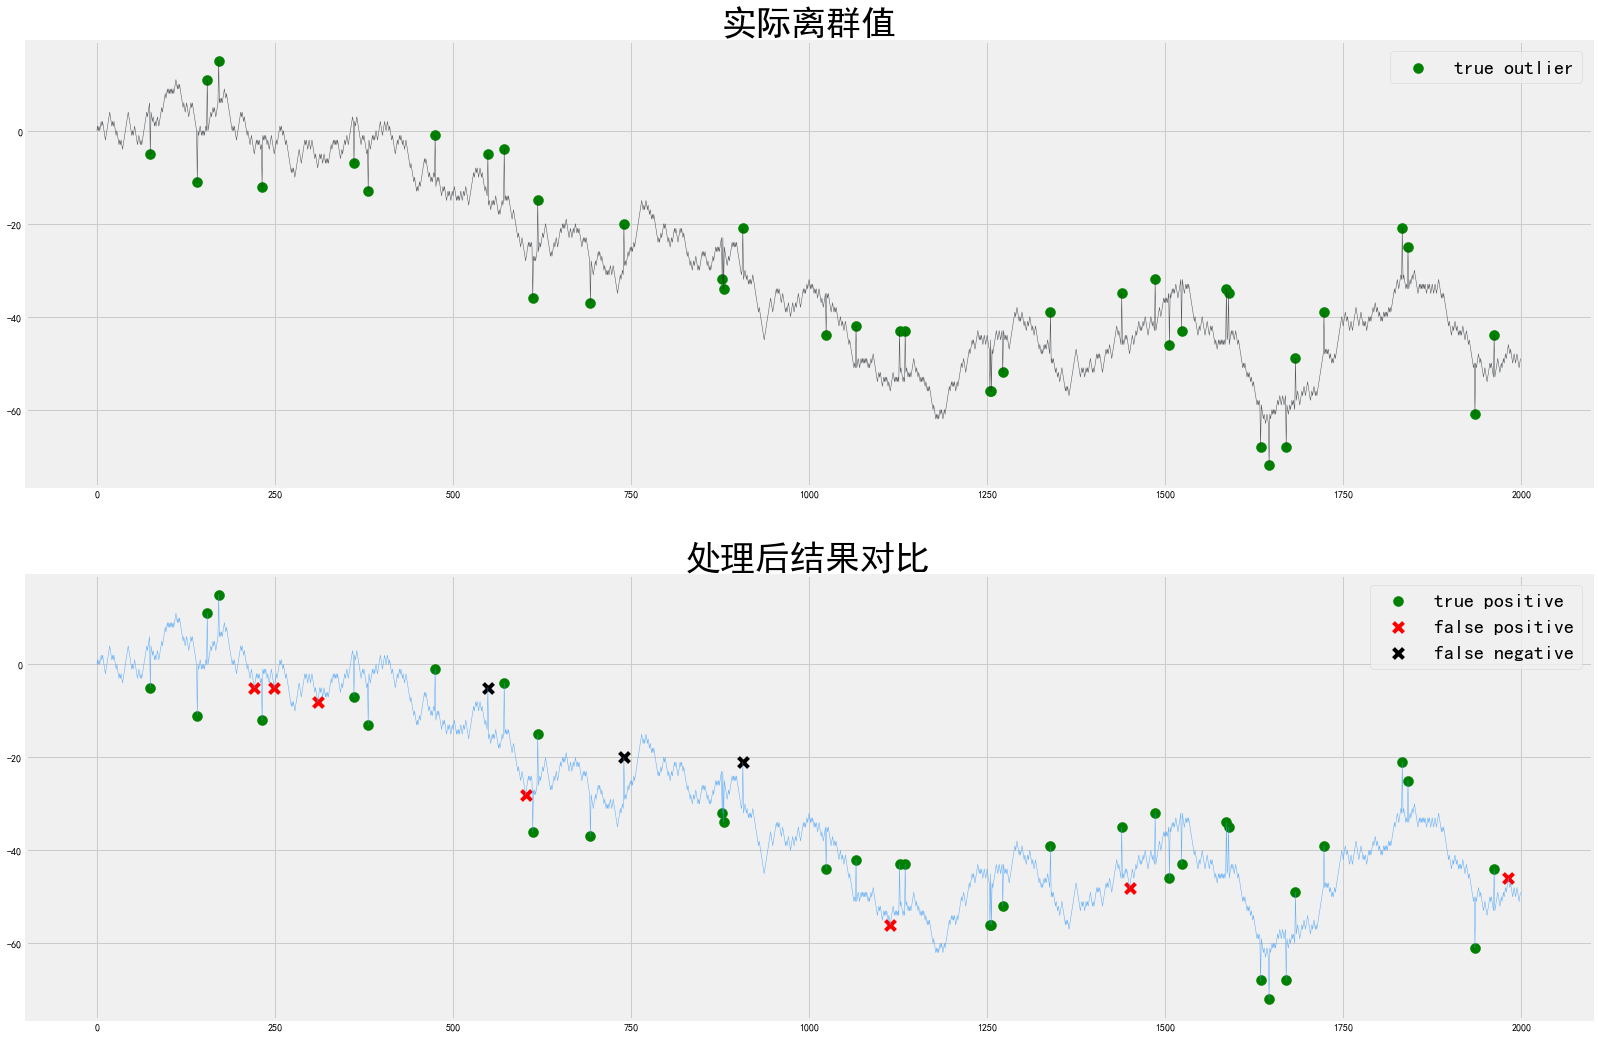

In [24]:
# IQR
tp, fp, fn = evaluation(rw, outlier_ind, detected_outliers_iqr)


<div align=center>
<img src=https://github.com/datoujinggzj/WhaleDataScienceProject/blob/master/pic/sep.gif?raw=true width='900' />
</div>



> Outliers are not labeled! (otherwise it’s just imbalanced classification)

> 在没有数据先验知识的情况下确定异常值。这属于于无监督聚类。

### DBSCAN

DBSCAN(Density-Based Spatial Clustering of Applications with Noise，具有噪声的基于密度的聚类方法)是一种很典型的密度聚类算法，和K-Means，BIRCH这些一般只适用于凸样本集的聚类相比，DBSCAN既可以适用于凸样本集，也可以适用于非凸样本集。

参考资料：https://www.cnblogs.com/pinard/p/6208966.html

In [25]:
from sklearn.cluster import DBSCAN

In [26]:
def plot_2d_space(X, y, label='Classes'):  
    
    colors = ['#20beff', '#d80012']
    markers = ['o', '*']
    plt.figure(figsize = [20,8])
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m,
            s = 80
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

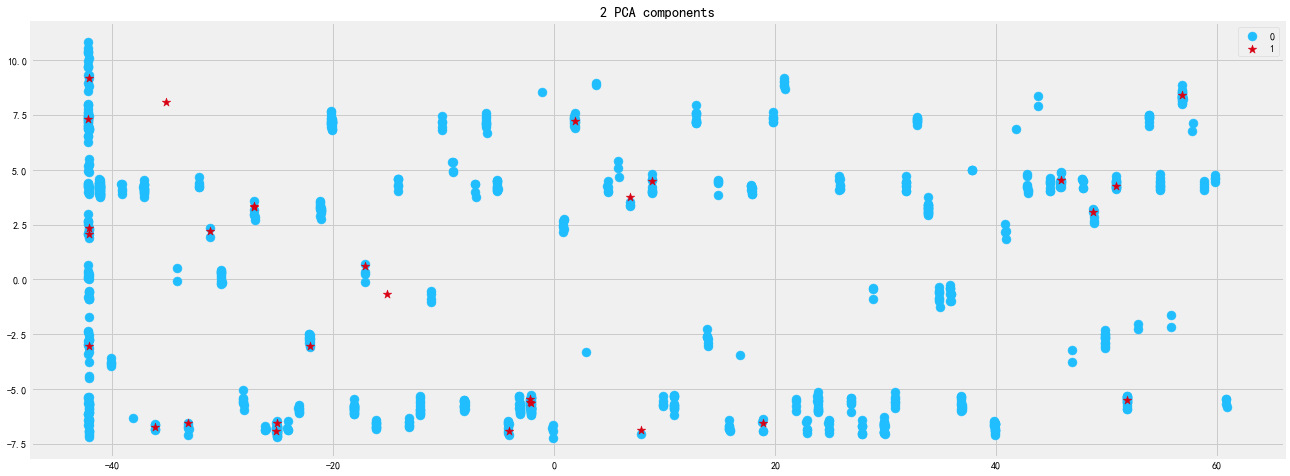

In [27]:
df = train.sample(1000)
X = df.drop(['id','target'],axis=1)
y = df.target

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plot_2d_space(X_pca, y, '2 PCA components')

In [28]:
dbscan=DBSCAN()
dbscan.fit(X_pca)
pass

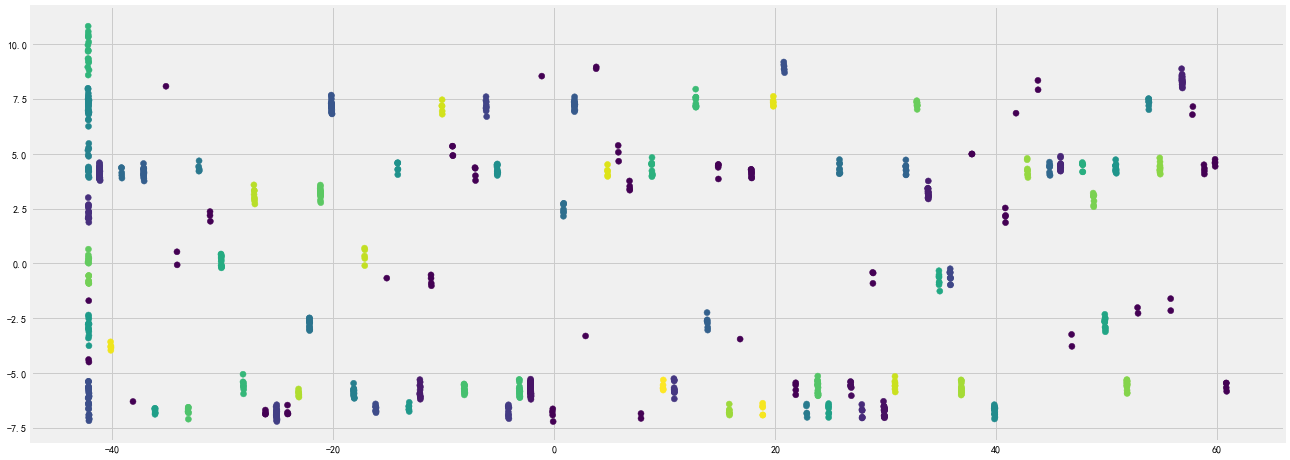

In [29]:
# visualize outputs
colors = dbscan.labels_
plt.figure(figsize = [20,8])
plt.scatter(X_pca[:,0], X_pca[:,1], c = colors)

麻了，这颜色类别怎么这么多，应该是对DBSCAN没有调节参数的原因！因为epsilon过于小了，那么如果找到一个合适的epsilon呢？

可以通过NearestNeighbors来获取数据点到其他最近的数据点的距离，distance的最高点就是epsilon的最优值啦！

In [30]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=10)
nbrs = neigh.fit(X_pca)
distances, indices = nbrs.kneighbors(X_pca)

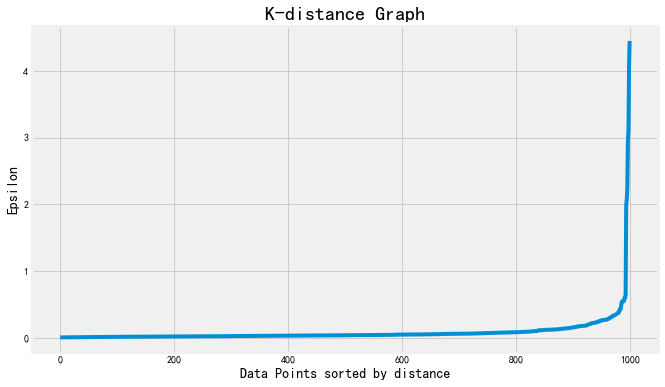

In [31]:
# Plotting K-distance Graph
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(10,6))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

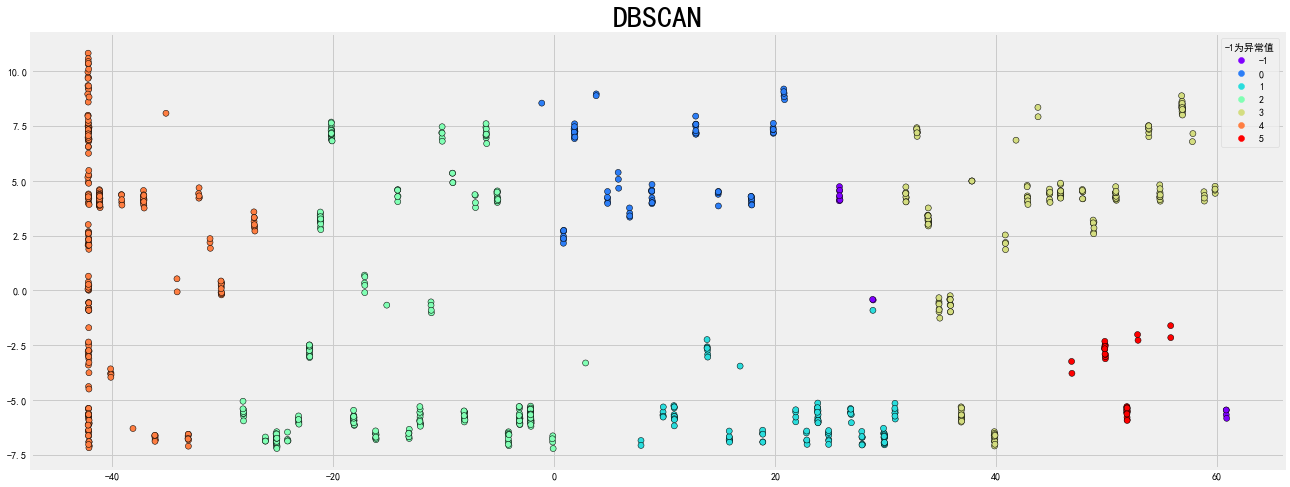

In [32]:
# 根据上图，eps = 5
model = DBSCAN(eps = 5, min_samples = 10).fit(X_pca)

colors = model.labels_
colormap = list(pd.Series(colors).unique())
plt.figure(figsize = [20,8])
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c = colors, cmap = 'rainbow',edgecolors='black')
plt.title('DBSCAN', fontsize = 30)
plt.legend(handles=scatter.legend_elements()[0], 
           labels=sorted(colormap),
           title="-1为异常值")

### EllipticEnvelope

Elliptic Envelope算法的思路是，假设常规数据隐含这一个已知的概率分布。基于这个假设，我们尝试确定数据的形状（边界），也可以将远离边界的样本点定义为异常点。

这是一种基于方差的鲁棒的异常检测值方法。该算法假设正常样本都符合高斯分布，并学习一个二维的椭圆分布。它根据数据做一个鲁棒的协方差估计，得到一组适合用来描述当前数据集的均值和方差，然后学习到一个包围中心样本点并且忽略离群点的椭圆，实现区分正常点和离群点的目的。

In [33]:
from sklearn.covariance import EllipticEnvelope

In [34]:
ee = EllipticEnvelope(contamination=0.1).fit(X_pca)
pred = ee.predict(X_pca)

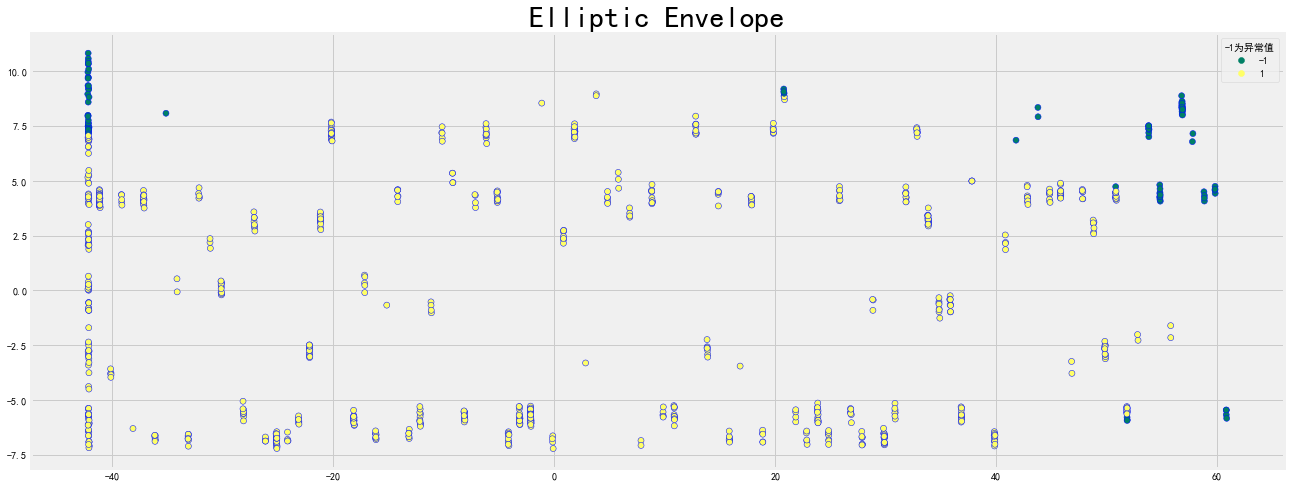

In [35]:
colors = pred
colormap = list(pd.Series(colors).unique())
plt.figure(figsize = [20,8])
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c = colors, cmap = 'summer',edgecolors='#000fff')
plt.title('Elliptic Envelope', fontsize = 30)
plt.legend(handles=scatter.legend_elements()[0], 
           labels=sorted(colormap),
           title="-1为异常值")

可以看出，这个结果并不好，因为最左边这一堆本来应该分成一类的，但是这个算法看起来是有明确的决策边界的，这是因为我们的数据不满足正态分布，让我检验一下！

可以使用D'Agostino and Pearson's Test。

In [36]:
IFrame(width="853",height="480",src = "https://www.youtube.com/embed/02I84i8Knas")

In [37]:
# D'Agostino and Pearson's Test
from numpy.random import seed
from numpy.random import randn
from scipy.stats import normaltest
seed(1)
stat, p = normaltest(X_pca[:,0])
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=1579.299, p=0.000
Sample does not look Gaussian (reject H0)


In [38]:
# D'Agostino and Pearson's Test
from numpy.random import seed
from numpy.random import randn
from scipy.stats import normaltest
seed(1)
stat, p = normaltest(X_pca[:,1])
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=5742.955, p=0.000
Sample does not look Gaussian (reject H0)


很明确，数据是不服从正态分布的，那么我们做一个demo高斯分布数据集，再去使用一下这个Elliptic Envelope方法！

In [39]:
x1 = 2*np.random.randn(10000)
x2 = np.random.randn(10000)+100

In [40]:
gaussian_demo = np.concatenate((x1.reshape(-1,1),x2.reshape(-1,1)),axis=1)
ee = EllipticEnvelope(contamination=0.05).fit(gaussian_demo)
pred = ee.predict(gaussian_demo)

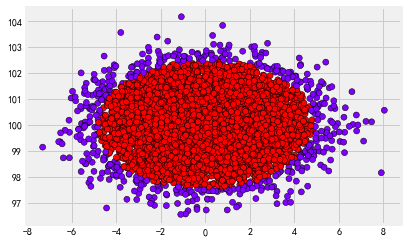

In [41]:
colors = pred
plt.scatter(x1, x2, c = colors, cmap = 'rainbow',edgecolors='black')

这就很完美，所以一定要先检验数据分布！

### OneClassSVM

这个算法的思路非常简单，就是寻找一个超平面将样本中的正例圈出来，预测就是用这个超平面做决策，在圈内的样本就认为是正样本。由于核函数计算比较耗时，在海量数据的场景用的并不多。

- Also uses Gaussian kernel to cover data

- Only select support vectors (not all points)

- Specify outlier ratio (contamination) via nu

In [42]:
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler

In [43]:
scaler = StandardScaler()
X_pca_scaled = scaler.fit_transform(X_pca)
oneclass = OneClassSVM(nu=.1).fit(X_pca_scaled)
pred = oneclass.predict(X_pca_scaled)

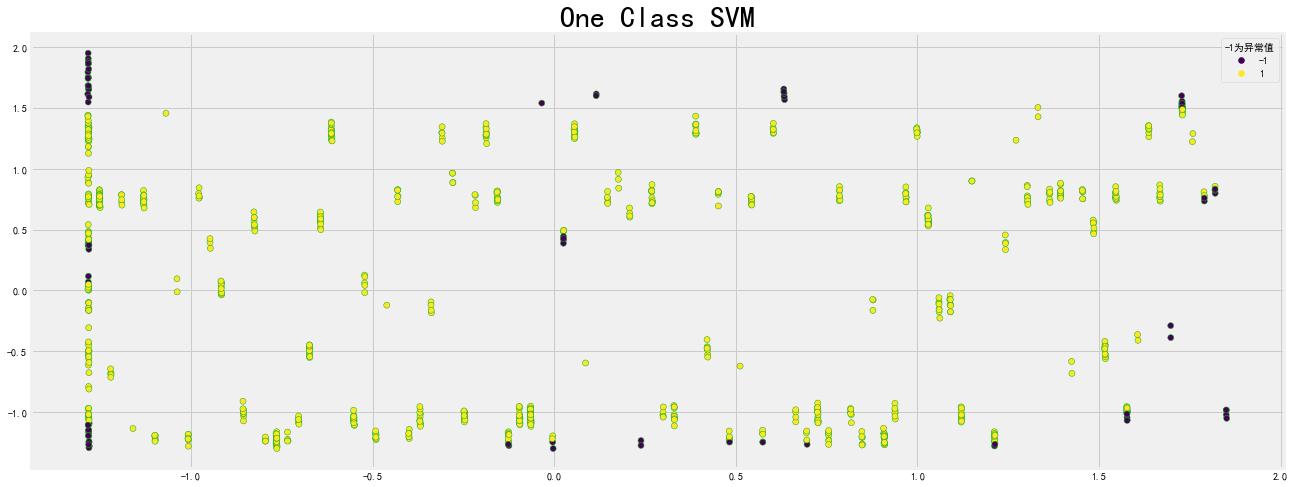

In [44]:
colors = pred
colormap = list(pd.Series(colors).unique())
plt.figure(figsize = [20,8])
scatter = plt.scatter(X_pca_scaled[:,0], X_pca_scaled[:,1], c = colors,edgecolors="#1aad19")
plt.title('One Class SVM', fontsize = 30)
plt.legend(handles=scatter.legend_elements()[0], 
           labels=sorted(colormap),
           title="-1为异常值")

### IsolationForests¶

孤立森林（isolation  Forest）是一种高效的异常检测算法，它和随机森林类似，但每次选择划分属性和划分点（值）时都是随机的，而不是根据信息增益或基尼指数来选择。

- non-parametric estimate 
- no probability model
- no parameters to tune



![](https://csdl-images.ieeecomputer.org/trans/tk/2021/04/figures/harir8-2947676.gif)

所以Isolation Forests的想法是，如果你在数据集上构建一棵随机树，那么如果你想弄清楚分割一个特定点有多容易，分割一个离群点要容易得多，那就是数据的外部，而不是数据非常密集的某个点。

这个想法是你构建了许多完全随机的树，它是完全无监督的，所以它只是以某种方式不断地分割数据，我们看看我们需要多深才能将一个数据点与其他数据点隔离开来。

如果平均而言，我们必须深入到树中，这可能是因为我们的一些数据很密集，它不是异常值。所以平均而言，如果我们很早就分离了这个点，它可能是一个异常值。

In [45]:
from sklearn.ensemble import IsolationForest

In [46]:
model=IsolationForest(n_estimators=50, max_samples='auto', contamination=float(0.1),max_features=1.0)
model.fit(X_pca_scaled)

scores =model.decision_function(X_pca_scaled)
pred =model.predict(X_pca_scaled)

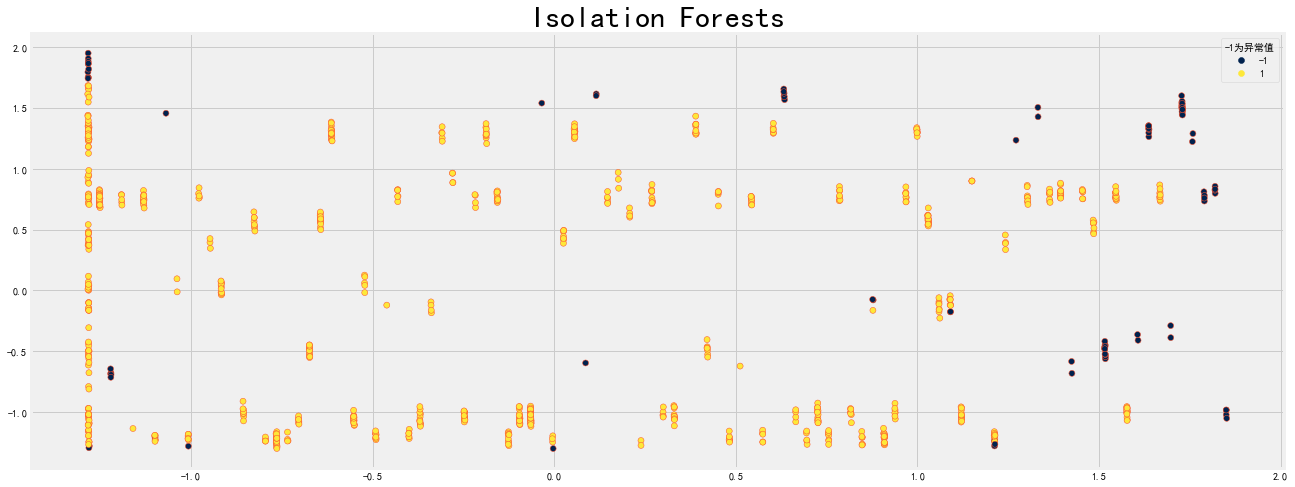

In [47]:
colors = pred
colormap = list(pd.Series(colors).unique())
plt.figure(figsize = [20,8])
scatter = plt.scatter(X_pca_scaled[:,0], X_pca_scaled[:,1], c = colors, cmap = 'cividis',edgecolors='#fc5531')
plt.title('Isolation Forests', fontsize = 30)
plt.legend(handles=scatter.legend_elements()[0], 
           labels=sorted(colormap),
           title="-1为异常值")

### LocalOutlierFactor

LOF通过计算一个数值score来反映一个样本的异常程度。这个数值的大致意思是：一个样本点周围的样本点所处位置的平均密度比上该样本点所在位置的密度。比值越大于1，则该点所在位置的密度越小于其周围样本所在位置的密度，这个点就越有可能是异常点。关于密度等理论概念，详见下面第二部分。

理论：https://blog.csdn.net/wangyibo0201/article/details/51705966

In [48]:
from sklearn.neighbors import LocalOutlierFactor

In [49]:
model = LocalOutlierFactor(n_neighbors=35, contamination=.1)
pred = model.fit_predict(X_pca_scaled)
scores = model.negative_outlier_factor_

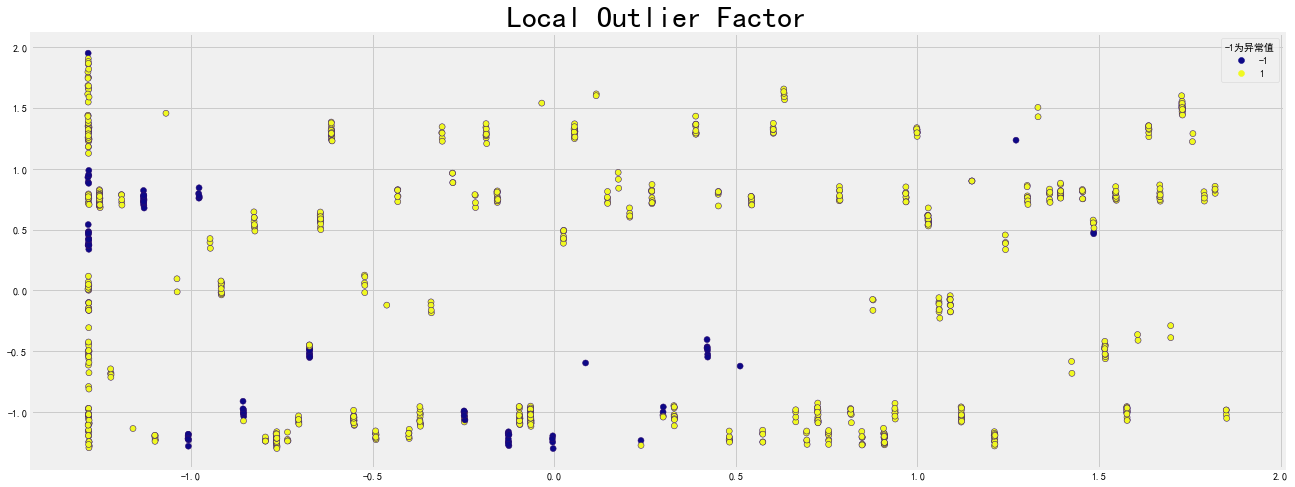

In [50]:
colors = pred
colormap = list(pd.Series(colors).unique())
plt.figure(figsize = [20,8])
scatter = plt.scatter(X_pca_scaled[:,0], X_pca_scaled[:,1], c = colors, cmap = 'plasma',edgecolors='#2f0c6f')
plt.title('Local Outlier Factor', fontsize = 30)
plt.legend(handles=scatter.legend_elements()[0], 
           labels=sorted(colormap),
           title="-1为异常值")

<div class="alert alert-block alert-info"> 
<p style="font-size:20px; display:inline">💡</p> 思考：对于大型数据集，像我们使用的这种，应该怎么有效处理异常值呢？
</div>

<div class="alert alert-block alert-info"> 
<p style="font-size:20px; display:inline">💡</p> 思考：novelty detection VS. outlier dection
</div>

点击进入Tushare教程：
https://mp.weixin.qq.com/s/hSMLH7UMczkLHZvH4mNwIg

In [51]:
# pip install tushare
import tushare as ts

In [52]:
df = ts.get_k_data('sh', start='2016-01-01')

本接口即将停止更新，请尽快使用Pro版接口：https://waditu.com/document/2


<AxesSubplot:title={'center':'收盘价时序趋势图'}, xlabel='date'>

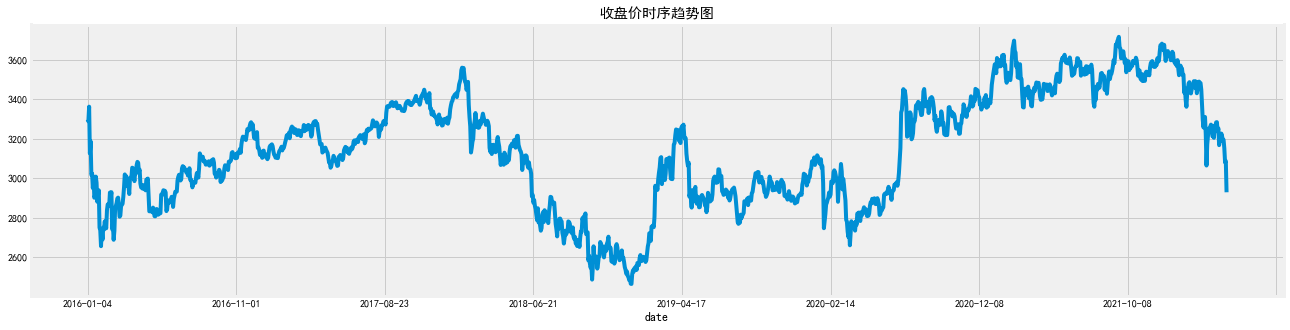

In [53]:
df.set_index('date').close.plot(figsize = [20,5],title = '收盘价时序趋势图')

<div class="alert alert-block alert-info"> 
<p style="font-size:20px; display:inline">💡</p> 思考：请用Z-score、IQR和Hampel分别检测一下异常值吧！
</div>

下一章节，我们将完善数据分析的后续内容，包括：

- 数据可视化
- 数据分析结果解释